### Simulation with full account of volume adjustment

In [1]:
import re
import collections as col
import cPickle as pkl
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
import platform
if platform.system()=="Windows":
    files = !dir ..\..\results\vol*
else:
    files = !ls ../../results/vol*

In [3]:
filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    if match:
        if platform.system()=="Windows":
            filepaths[int(match.group(1).zfill(4))] = r"..\\..\\results\\" + file[file.index("polyphasic"):]
            # because the output of dir is more complex than that of ls
        else:
            filepaths[int(match.group(1).zfill(4))] = file

In [4]:
for time in filepaths:
    print time,
    #replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")  # takes time, run only once

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


Load proteome:

In [5]:
results = {}
proteome = {}
for time in filepaths:
    print time, filepaths[time]
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-1}

0 ../../results/volume-adjusted polyphasic cell cycle from 0 to 300, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20170404_0842_200000_ribosomes_2100s.p
2400 ../../results/volume-adjusted polyphasic cell cycle from 2400 to 2700, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20170404_1317_286153_ribosomes_2100s.p
3300 ../../results/volume-adjusted polyphasic cell cycle from 3300 to 3600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20170404_1501_318461_ribosomes_2100s.p
1800 ../../results/volume-adjusted polyphasic cell cycle from 1800 to 2100, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20170404_1202_264615_ribosomes_2100s.p
300 ../../results/volume-adjusted polyphasic cell cycle from 300 to 600, Teufel transcriptome, full

In [6]:
transcriptomes_dict = col.OrderedDict(sorted(
        pkl.load((open('../../parameters/transcriptome_time_dependent.p'))).items()))

In [7]:
transcriptome_df = pd.DataFrame(transcriptomes_dict).transpose()
del transcriptome_df[0]
transcriptome_df.index = np.arange(0, 3601, 300)
transcriptome_df

,Q0010,Q0017,Q0032,Q0045,Q0050,Q0055,Q0060,Q0065,Q0070,Q0075,...,YPR196W,YPR197C,YPR198W,YPR199C,YPR200C,YPR201W,YPR202W,YPR203W,YPR204C-A,YPR204W
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
600,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
900,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,0
1200,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
1500,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,0,0
1800,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,0,0,0
2100,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,0
2400,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2700,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [8]:
translation_rate_shortlist = {}
genes = transcriptomes_dict[0].keys()[1:]

for gene in genes:
    translation_rate_shortlist[gene] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-301])/300.
        else:
            rate = 0.
        translation_rate_shortlist[gene].append(rate)

translation_ratedf = pd.DataFrame(translation_rate_shortlist, index=np.arange(0, 3600, 300))

In [9]:
translation_rate_per_mrna = translation_ratedf / transcriptome_df
translation_rate_per_mrna.dropna(axis=1, how='all', inplace=True)
translation_rate_per_mrna

,YAL001C,YAL002W,YAL003W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,...,YPR187W,YPR188C,YPR189W,YPR190C,YPR191W,YPR192W,YPR196W,YPR198W,YPR199C,YPR200C
0,NaN,0.056667,0.253922,0.0,0.130000,0.130000,0.060000,NaN,NaN,0.210952,...,0.143333,0.113333,0.076667,0.076667,0.113333,NaN,NaN,NaN,NaN,NaN
300,0.056667,NaN,0.252308,0.0,0.136667,0.163333,NaN,NaN,NaN,0.209474,...,0.154167,0.120000,0.066667,0.076667,0.130000,NaN,NaN,NaN,NaN,NaN
600,0.010000,0.003333,0.150347,0.0,0.059444,0.085000,0.028333,NaN,0.036667,0.119436,...,0.070256,0.055000,0.035000,0.036667,0.048333,NaN,NaN,0.036667,NaN,0.0
900,0.030000,0.010000,0.149869,0.0,0.067333,0.091111,0.031667,0.023333,0.045000,0.120437,...,0.075897,0.053333,0.048333,0.040000,0.060000,NaN,NaN,0.050000,0.023333,NaN
1200,0.043333,0.010000,0.153529,0.0,0.061333,0.083333,0.036667,NaN,0.030000,0.123030,...,0.076000,0.065556,0.056667,0.045333,0.060000,NaN,NaN,0.060000,0.020000,0.0
1500,0.011667,0.013333,0.107633,0.0,0.047083,0.066667,0.019444,NaN,0.023333,0.083539,...,0.042857,0.040000,0.024167,0.028889,0.047778,0.0,0.0,0.036667,0.010000,NaN
1800,0.015000,0.021667,0.107967,0.0,0.042917,0.048333,0.016000,0.020000,0.018333,0.087174,...,0.052963,0.031111,0.025833,0.028889,0.050000,NaN,NaN,0.026667,0.013333,NaN
2100,0.016667,0.008889,0.110769,0.0,0.042083,0.066667,0.020833,0.020000,0.025000,0.086667,...,0.053175,0.035556,0.025000,0.020476,0.043333,NaN,NaN,0.023333,0.020000,NaN
2400,0.043333,0.020000,0.203457,0.0,0.085000,0.130000,0.041111,NaN,NaN,0.167374,...,0.105455,0.086667,0.058333,0.070000,0.093333,NaN,NaN,0.086667,0.020000,NaN
2700,0.056667,0.023333,0.201986,0.0,0.093333,0.133333,0.050000,NaN,0.070000,0.168780,...,0.110303,0.088333,0.063333,0.055000,0.091667,NaN,NaN,0.070000,0.016667,NaN


In [10]:
translation_rate_per_mrna.mean(axis=1, skipna=True)

0       0.093837
300     0.095032
600     0.040945
900     0.042350
1200    0.043535
1500    0.027455
1800    0.027322
2100    0.027900
2400    0.066524
2700    0.066169
3000    0.089720
3300    0.062464
3600         NaN
dtype: float64

In [11]:
import matplotlib.collections as collections

In [12]:
t = np.arange(0.0, 61.0, 2.5)

Transcript abundance and translational efficiency:

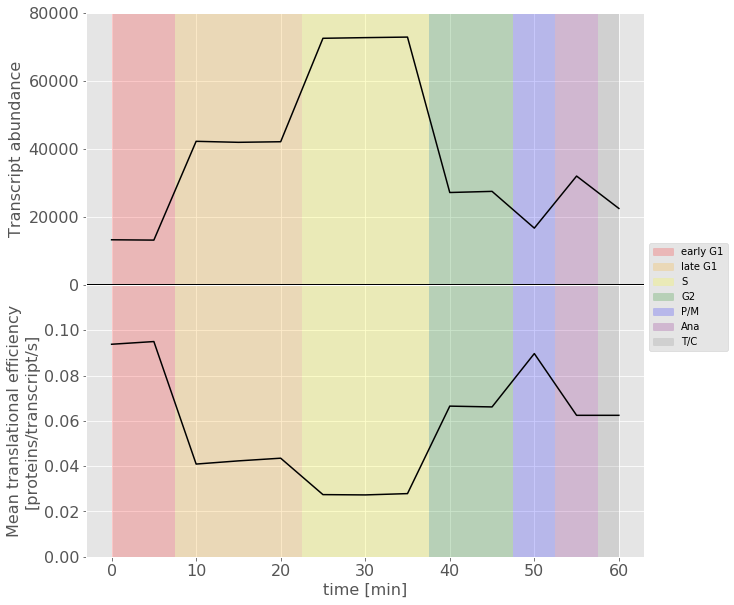

In [13]:
plt.rcParams['figure.figsize'] = (10, 10)

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5)
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_rate_per_mrna.mean(axis=1, skipna=True).values[:-1]
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0), y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=16)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 7.6, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t > 57.4, facecolor='grey', alpha=0.2)
ax.add_collection(collection)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='early G1', alpha=0.2)
orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=0.2)
yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='G2', alpha=0.2)
blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=0.2)
purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=0.2)
grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=0.2)

plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch, grey_patch], 
           loc='lower left', bbox_to_anchor=(1, 0.74), fancybox=True, framealpha=1.0)

# plt.text(1.0, 5000, "early G1", fontsize=16, weight="bold")

#######################################################################################################################
ax2.plot(x2, y2, color='black')

ax = ax2
pos = np.arange(0.0, 0.11, 0.02)
ax.set_yticks(pos)
ax.set_yticklabels(["%.2f" % round(p,2) for p in pos], fontsize=16)
ax.set_ylabel("Mean translational efficiency\n[proteins/transcript/s]", fontsize=16)
ax.set_xlabel("time [min]", fontsize=16)


collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=t < 7.6, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=t > 57.4, facecolor='grey', alpha=0.2)
ax.add_collection(collection)

plt.ylim([0, 0.12])

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

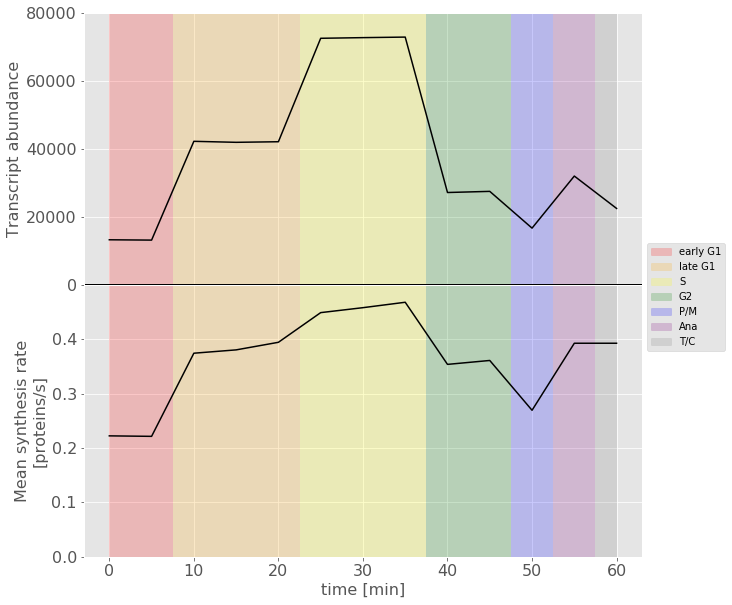

In [14]:
plt.rcParams['figure.figsize'] = (10, 10)

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5)
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_ratedf.mean(axis=1, skipna=True).values
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0), y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=16)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 7.6, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t > 57.4, facecolor='grey', alpha=0.2)
ax.add_collection(collection)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='early G1', alpha=0.2)
orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=0.2)
yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='G2', alpha=0.2)
blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=0.2)
purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=0.2)
grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=0.2)

plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch, grey_patch], 
           loc='lower left', bbox_to_anchor=(1, 0.74), fancybox=True, framealpha=1.0)

# plt.text(1.0, 5000, "early G1", fontsize=16, weight="bold")

#######################################################################################################################
ax2.plot(x2, y2, color='black')

ymax = 0.5

ax = ax2
pos = np.arange(0.0, ymax, 0.1)
ax.set_yticks(pos)
ax.set_yticklabels(["%.1f" % round(p,1) for p in pos], fontsize=16)
ax.set_ylabel("Mean synthesis rate\n[proteins/s]", fontsize=16)
ax.set_xlabel("time [min]", fontsize=16)


collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=t < 7.6, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=t > 57.4, facecolor='grey', alpha=0.2)
ax.add_collection(collection)

plt.ylim([0, ymax])

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

Only transcript abundance:

In [15]:
matplotlib.use("pgf")
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [u'Adobe Caslon Pro'],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1407: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


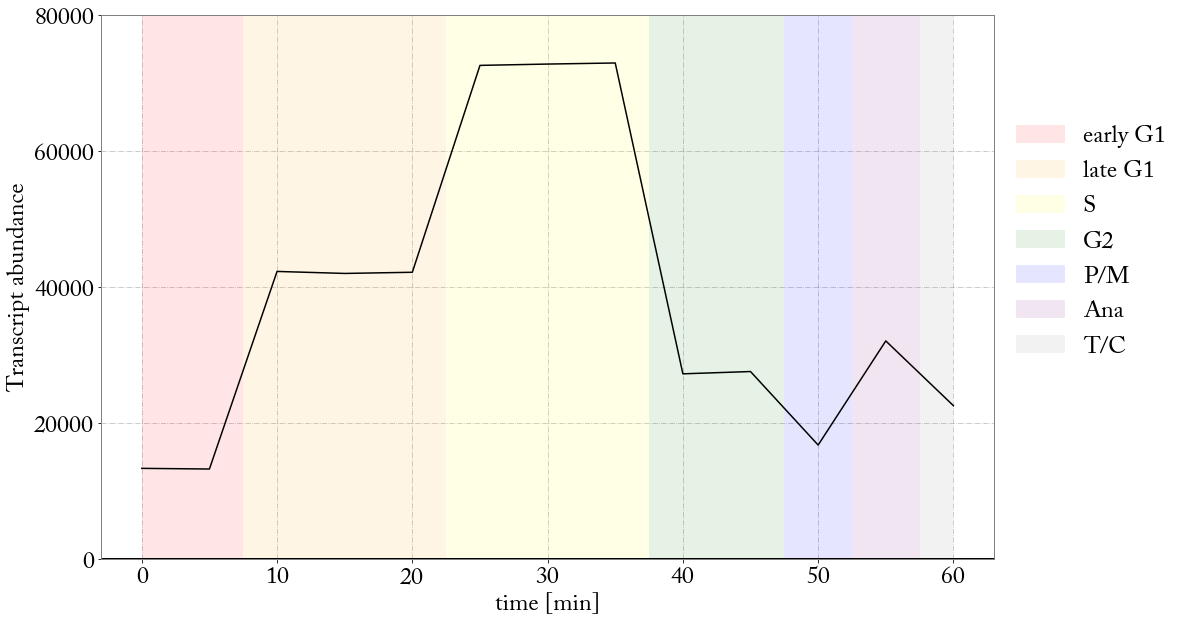

In [19]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='grey'
plt.rcParams['grid.color']='grey'
plt.rcParams['grid.alpha']='0.5'
plt.rcParams['grid.linestyle']='-.'

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5)
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]


#######################################################################################################################
f, ax1 = plt.subplots(1)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=24)
ax.yaxis.label.set_color('black')
plt.tick_params(axis='both', which='major', labelsize=24)

myalpha = 0.1
pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=24)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 7.6, facecolor='red', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t > 57.4, facecolor='grey', alpha=myalpha)
ax.add_collection(collection)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='early G1', alpha=myalpha)
orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=myalpha)
yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=myalpha)
green_patch = mpatches.Patch(color='green', label='G2', alpha=myalpha)
blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=myalpha)
purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=myalpha)
grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=myalpha)

lgd = plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch, grey_patch], 
           loc='lower left', bbox_to_anchor=(1, 0.33), fancybox=True, framealpha=0.0, fontsize=24)

ax1.set_xlabel("time [min]", fontsize=24)
ax1.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#plt.tight_layout()
plt.savefig('time_resolved_transcriptome.pgf', bbox_extra_artists=(lgd,), bbox_inches='tight')